# Highway Crashes
---

# Long-range Forecasting and Pattern Discovery given Limited Data

In [2]:
# %load setup_bayes.py
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
# import theano
# import theano.tensor as tt
# import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
# from bqplot import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from beakerx import *
sns.set_context('notebook', font_scale = 1.1)
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 'lines.linewidth': 2.0, 
      'lines.markersize': 8, 'font.family': "serif", 'font.serif': "cm", 'savefig.dpi': 200,
      'text.usetex': False, 'legend.fontsize': 20.0, 'axes.titlesize': 20, "figure.figsize": [20, 12]}
sns.set(rc = rc)
sns.set_style("whitegrid")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gpflow
from gpflowopt.domain import ContinuousParameter
from gpflowopt.bo import BayesianOptimizer
from gpflowopt.acquisition import ExpectedImprovement, MinValueEntropySearch
from gpflowopt.optim import StagedOptimizer, MCOptimizer, SciPyOptimizer  
from gpflowopt.design import LatinHyperCube
import random
random.seed(1234)
from warnings import filterwarnings
filterwarnings("ignore")

/Users/demaasit/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Data Preparation

In [3]:
monthly_crash_data = pd.read_csv("../../data/monthly_data.csv")
monthly_crash_data.head()

In [4]:
pd.read_csv("../../data/monthly_data.csv")

In [5]:
# Check the data types of each variable
monthly_crash_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 4 columns):
Year               240 non-null int64
Month              240 non-null int64
Fatalities         240 non-null int64
SeriousInjuries    240 non-null int64
dtypes: int64(4)
memory usage: 7.6 KB


Create a new datetime column labelled "ds" that combines original columns "Year" and "Month"


In [6]:
from datetime import datetime
monthly_crash_data["ds"] = monthly_crash_data["Year"].map(str) + "-" + monthly_crash_data["Month"].map(str)
monthly_crash_data["ds"] = pd.to_datetime(monthly_crash_data["ds"])
monthly_crash_data["ds"] = monthly_crash_data.ds.astype("O")
monthly_crash_data.tail()

In [7]:
from datetime import datetime
monthly_crash_data["ds"] = monthly_crash_data.apply(lambda x: datetime.date(x["ds"]), axis = 1)

In [8]:
# Check again the data types of each variable
monthly_crash_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 5 columns):
Year               240 non-null int64
Month              240 non-null int64
Fatalities         240 non-null int64
SeriousInjuries    240 non-null int64
ds                 240 non-null object
dtypes: int64(4), object(1)
memory usage: 9.5+ KB


In [11]:
fatal_crash_data = monthly_crash_data[["ds", "Fatalities"]].rename(columns = {"Fatalities" : "y"})
fatal_crash_data.head()

visualize fatal crashes

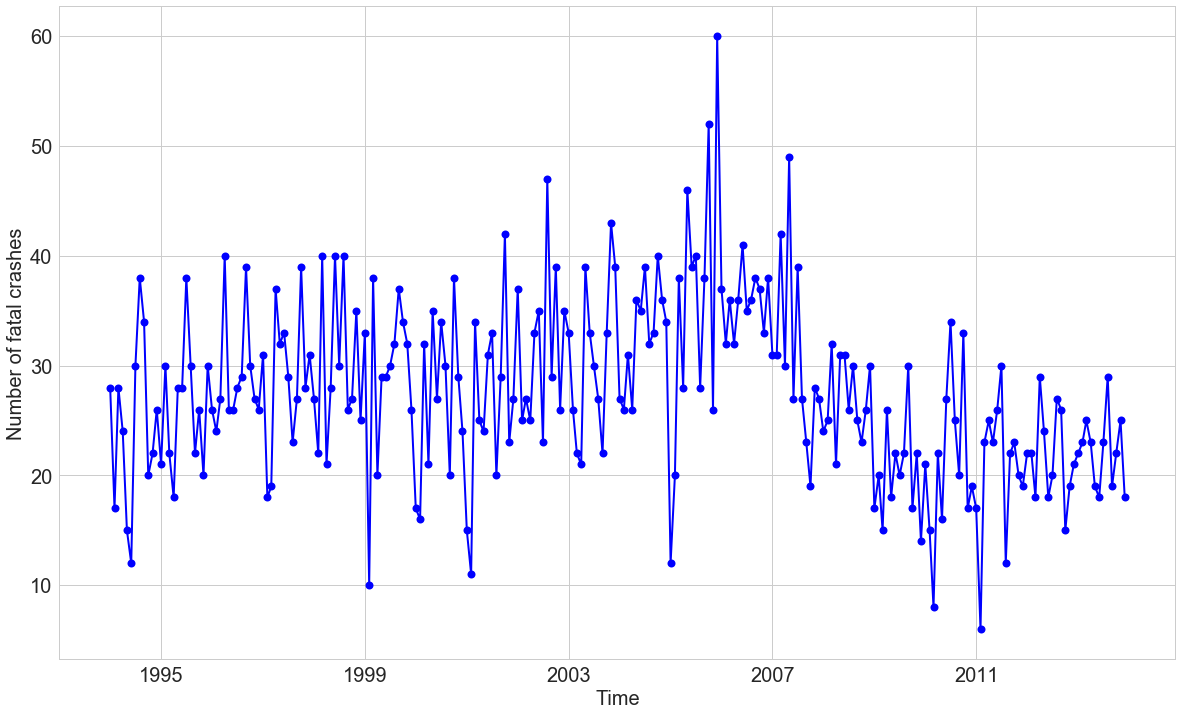

In [12]:
fig, ax = plt.subplots()
ax.plot(fatal_crash_data.ds, fatal_crash_data.y, color = "b", marker = "o")
# ax.set_xticklabels(labels = fatal_crash_data.ds, rotation = 45)
ax.set_xlabel("Time")
ax.set_ylabel("Number of fatal crashes");
# ax.set_title("Number of Fatal Crashes");

In [13]:
injury_crash_data = monthly_crash_data[["ds", "SeriousInjuries"]].rename(columns = {"SeriousInjuries" : "y"})
injury_crash_data.head()

In [14]:
injury_crash_data[injury_crash_data.index == 192]

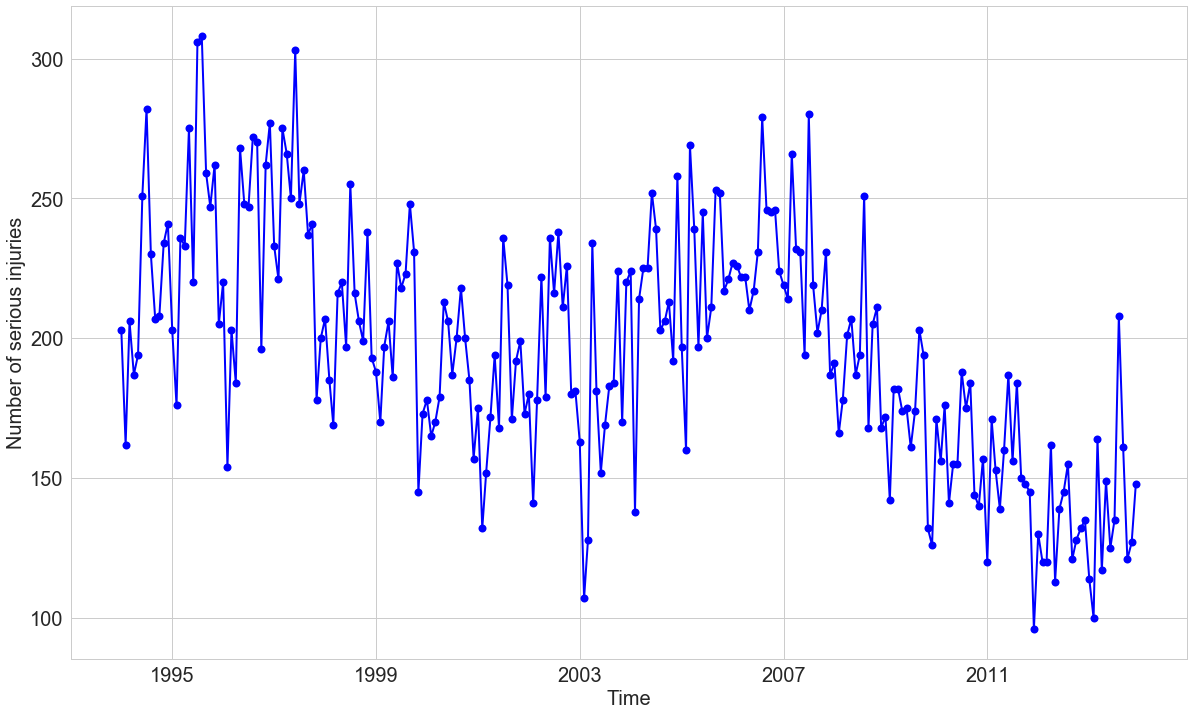

In [15]:
fig, ax = plt.subplots()
ax.plot(injury_crash_data.ds, injury_crash_data.y, color = "b", marker = "o")
# ax.set_xticklabels(labels = injury_crash_data.ds, rotation = 45)
ax.set_xlabel("Time")
ax.set_ylabel("Number of serious injuries");
# ax.set_title("Number of Emails sent Monthly");

In [16]:
X_complete = np.array([injury_crash_data.index]).reshape((240, 1)).astype('float64')
X_train = X_complete[0:203, ]
X_test = X_complete[204:240, ]
Y_complete = np.array([injury_crash_data.y]).reshape((240, 1)).astype('float64')
Y_train = Y_complete[0:203, ]
Y_test = Y_complete[204:240, ]
D = Y_train.shape[1];

In [17]:
D

1

In [18]:
Y_train.shape; X_train.shape; Y_test.shape; X_test.shape; X_complete.shape

(203, 1)

(203, 1)

(36, 1)

(36, 1)

(240, 1)

In [19]:
Y_train[0:3, ]; X_train[0:3, ]; X_test[0:3, ]; X_complete[0:3, ]

array([[ 203.],
       [ 162.],
       [ 206.]])

array([[ 0.],
       [ 1.],
       [ 2.]])

array([[ 204.],
       [ 205.],
       [ 206.]])

array([[ 0.],
       [ 1.],
       [ 2.]])

In [20]:
Y_train.dtype

dtype('float64')

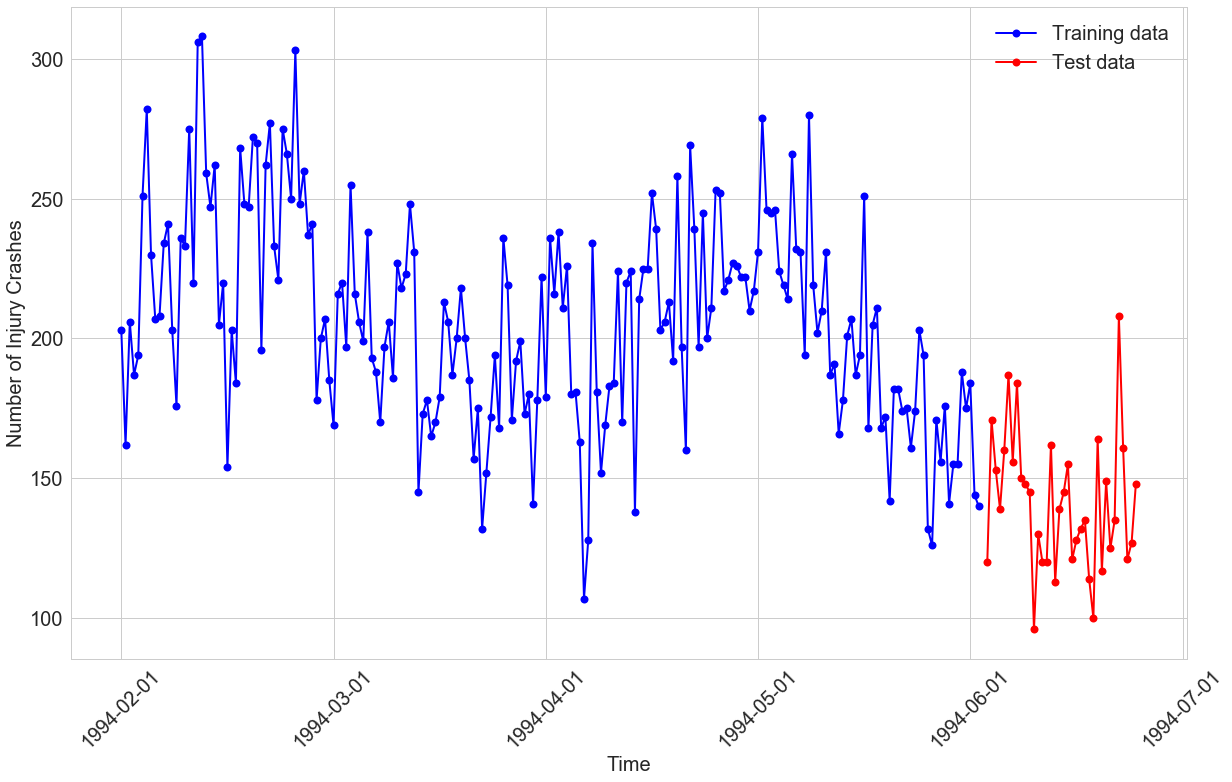

In [21]:
fig, ax = plt.subplots()
ax.plot(X_train.flatten(),Y_train.flatten(), c ='b', marker = "o", label = "Training data")
ax.plot(X_test.flatten(),Y_test.flatten(), c='r', marker = "o", label = 'Test data')
ax.set_xticklabels(labels = injury_crash_data.ds, rotation = 45)
ax.set_xlabel('Time')
ax.set_ylabel('Number of Injury Crashes')
plt.legend(loc = "best");
# fig1 = plt.gcf()
# py.offline.iplot_mpl(fig1);

## Gaussian Process modeling

In [28]:
# Trains a model with a spectral mixture kernel, given an ndarray of 
# 2Q frequencies and lengthscales

Q = 10 # nr of terms in the sum
max_iters = 1000

def create_model(hypers):
    f = np.clip(hypers[:Q], 0, 5)
    weights = np.ones(Q) / Q
    lengths = hypers[Q:]

    kterms = []
    for i in range(Q):
        rbf = gpflow.kernels.RBF(D, lengthscales=lengths[i], variance=1./Q)
        rbf.lengthscales.transform = gpflow.transforms.Exp()
        cos = gpflow.kernels.Cosine(D, lengthscales=f[i])
        kterms.append(rbf * cos)

    k = np.sum(kterms) + gpflow.kernels.Linear(D) + gpflow.kernels.Bias(D)
    m = gpflow.gpr.GPR(X_train, Y_train, kern=k)
    return m

m = create_model(np.ones((2*Q,)))

In [61]:
%%time
m.optimize(maxiter = max_iters)

CPU times: user 13.5 s, sys: 1.72 s, total: 15.3 s
Wall time: 9.1 s


      fun: 1004.2134731337928
 hess_inv: <43x43 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.92198850e-05,   3.19416332e-05,  -7.93365308e-19,
         1.77192638e-08,  -2.01665357e-06,   3.97534986e-06,
        -7.93365308e-19,   1.77192638e-08,  -2.01665357e-06,
         3.97534986e-06,  -7.93365308e-19,   1.77192638e-08,
        -2.01665357e-06,   3.97534986e-06,  -7.93365308e-19,
         1.77192638e-08,  -2.01665357e-06,   3.97534986e-06,
        -7.93365308e-19,   1.77192638e-08,  -2.01665357e-06,
         3.97534986e-06,  -7.93365308e-19,   1.77192638e-08,
        -2.01665357e-06,   3.97534986e-06,  -7.93365308e-19,
         1.77192638e-08,  -2.01665357e-06,   3.97534986e-06,
        -7.93365308e-19,   1.77192638e-08,  -2.01665357e-06,
         3.97534986e-06,  -7.93365308e-19,   1.77192638e-08,
        -2.01665357e-06,   3.97534986e-06,  -7.93365308e-19,
         1.77192638e-08,  -2.01665357e-06,   3.97534986e-06,
        -0.00000000e+00])
  message: b'CONVERGE

In [23]:
def plotprediction(m):
    # Perform prediction
    mu, var = m.predict_f(X_complete)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticklabels(labels = injury_crash_data.ds, rotation = 45)
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Injury Crashes');
    ax.plot(X_train.flatten(),Y_train.flatten(), c='r', label = 'Training data')
    ax.plot(X_test.flatten(),Y_test.flatten(), c='b', label = 'Test data')
    ax.plot(X_complete.flatten(), mu.flatten(), c='g', label = "Predicted mean function")
    lower = mu - 2*np.sqrt(var)
    upper = mu + 2*np.sqrt(var)
    ax.plot(X_complete, upper, 'g--', X_complete, lower, 'g--', lw=1.2)
    ax.fill_between(X_complete.flatten(), lower.flatten(), upper.flatten(),
                    color='g', alpha=.1, label = "95% Predicted Credible interval")
    plt.legend(loc = "best")
    plt.tight_layout()

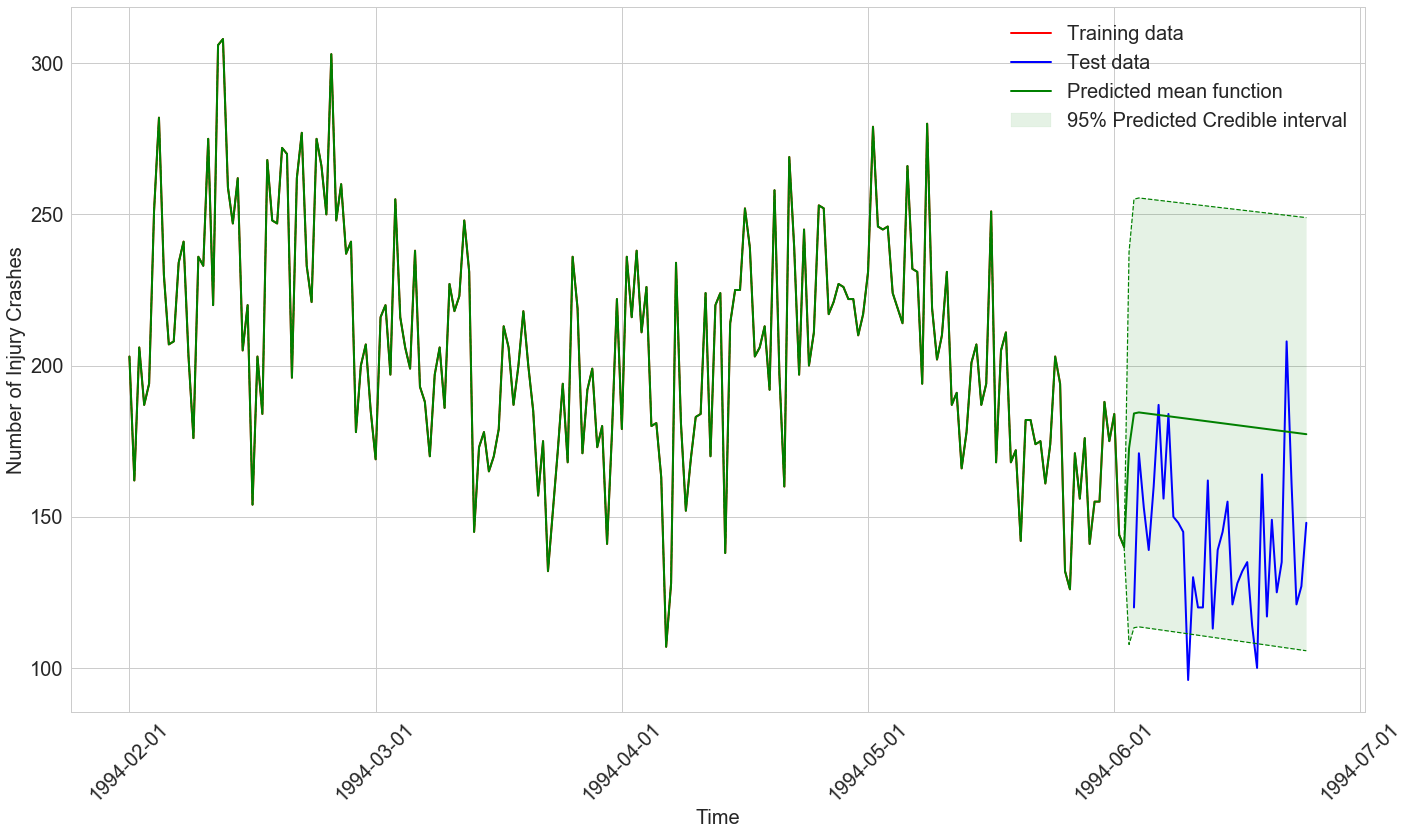

In [24]:
plotprediction(m);

## Perform hyperparameter tuning using Bayesian Optimization

Let's use Bayesian Optimization to find the optimal model parameters of the GP model and then use then to estimate the model and prediction.

In [64]:
from gpflowopt.objective import batch_apply

# Objective function for our optimization
# Input: N x 2Q ndarray, output: N x 1.
# returns the negative log likelihood obtained by training with given frequencies and rbf lengthscales
# Applies some tricks for stability similar to GPy's jitchol
@batch_apply
def objectivefx(freq):
    m = create_model(freq)
    for i in [0] + [10**exponent for exponent in range(6,1,-1)]:
        try:
            mean_diag = np.mean(np.diag(m.kern.compute_K_symm(X_train)))
            m.likelihood.variance = 1 + mean_diag * i
            m.optimize(maxiter=max_iters)
            return -m.compute_log_likelihood()
        except:
            pass
    raise RuntimeError("Frequency combination failed indefinately.")

# Setting up optimization domain.
lower = [0.]*Q
upper = [5.]*int(Q)
df = np.sum([ContinuousParameter('freq{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])

lower = [1e-5]*Q
upper = [300]*int(Q)
dl = np.sum([ContinuousParameter('l{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])
domain = df + dl
domain

Name,Type,Values
freq0,Continuous,[ 0. 5.]
freq1,Continuous,[ 0. 5.]
freq2,Continuous,[ 0. 5.]
freq3,Continuous,[ 0. 5.]
freq4,Continuous,[ 0. 5.]
freq5,Continuous,[ 0. 5.]
freq6,Continuous,[ 0. 5.]
freq7,Continuous,[ 0. 5.]
freq8,Continuous,[ 0. 5.]
freq9,Continuous,[ 0. 5.]


In [65]:
%%time
design = LatinHyperCube(6, domain)
X = design.generate()

CPU times: user 1min 2s, sys: 19.4 s, total: 1min 22s
Wall time: 1min 24s


In [66]:
%%time
Y = objectivefx(X)

/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/transforms.py:112: RuntimeWarning: divide by zero encountered in log
  return np.log(y - self._lower)


CPU times: user 4min 33s, sys: 13 s, total: 4min 46s
Wall time: 3min 59s


In [67]:
%%time
k_surrogate = gpflow.kernels.Matern52(input_dim = domain.size, ARD = False)

CPU times: user 157 µs, sys: 1 µs, total: 158 µs
Wall time: 164 µs


In [68]:
%%time
model_surrogate = gpflow.gpr.GPR(X, Y, kern = k_surrogate)

CPU times: user 559 µs, sys: 275 µs, total: 834 µs
Wall time: 595 µs


In [69]:
%%time
acq_fn = ExpectedImprovement(model_surrogate)
# acq_fn = MinValueEntropySearch(model_surrogate, domain = domain)

CPU times: user 1min 17s, sys: 1.34 s, total: 1min 19s
Wall time: 1min 19s


In [70]:
%%time
acq_optimizer = StagedOptimizer([MCOptimizer(domain, nsamples = 5000), 
                                SciPyOptimizer(domain)])

CPU times: user 1.45 ms, sys: 1.13 ms, total: 2.58 ms
Wall time: 1.93 ms


In [71]:
%%time
optimizer = BayesianOptimizer(domain = domain, 
                              acquisition = acq_fn, 
                              optimizer = acq_optimizer)

CPU times: user 18.8 s, sys: 355 ms, total: 19.2 s
Wall time: 19.2 s


In [25]:
%%time
with optimizer.silent():
    result = optimizer.optimize(objectivefx = objectivefx, n_iter = 30)

In [26]:
print(result)

     fun: array([ 958.87232991])
 message: 'OK'
    nfev: 30
 success: True
       x: array([[   3.80529787,    2.94138925,    3.46855028,    3.69130094,
           3.4051466 ,    3.69430538,    2.60441792,    3.57734587,
           2.90336201,    2.8856748 ,  183.64048191,  158.84519472,
         171.72548979,  188.11891616,  213.7448481 ,  220.72791419,
          84.58863382,    8.3279239 ,    8.5962913 ,    4.23286194]])


In [29]:
%%time
m_opt = create_model(result.x[0,:])
m_opt.optimize()

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: name.build_likelihood/Cholesky = Cholesky[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"](name.build_likelihood/add)]]

Caused by op 'name.build_likelihood/Cholesky', defined at:
  File "/Users/demaasit/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/demaasit/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-4156f63a26e2>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', 'm_opt = create_model(result.x[0,:])\nm_opt.optimize()')
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2131, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-62>", line 2, in time
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1238, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 2, in <module>
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/model.py", line 250, in optimize
    return self._optimize_np(method, tol, callback, maxiter, **kw)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/model.py", line 311, in _optimize_np
    self.compile()
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/model.py", line 156, in compile
    f = self.build_likelihood() + self.build_prior()
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/scoping.py", line 43, in runnable
    return f(*args, **kwargs)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/gpr.py", line 60, in build_likelihood
    L = tf.cholesky(K)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 420, in cholesky
    "Cholesky", input=input, name=name)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/demaasit/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: name.build_likelihood/Cholesky = Cholesky[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"](name.build_likelihood/add)]]


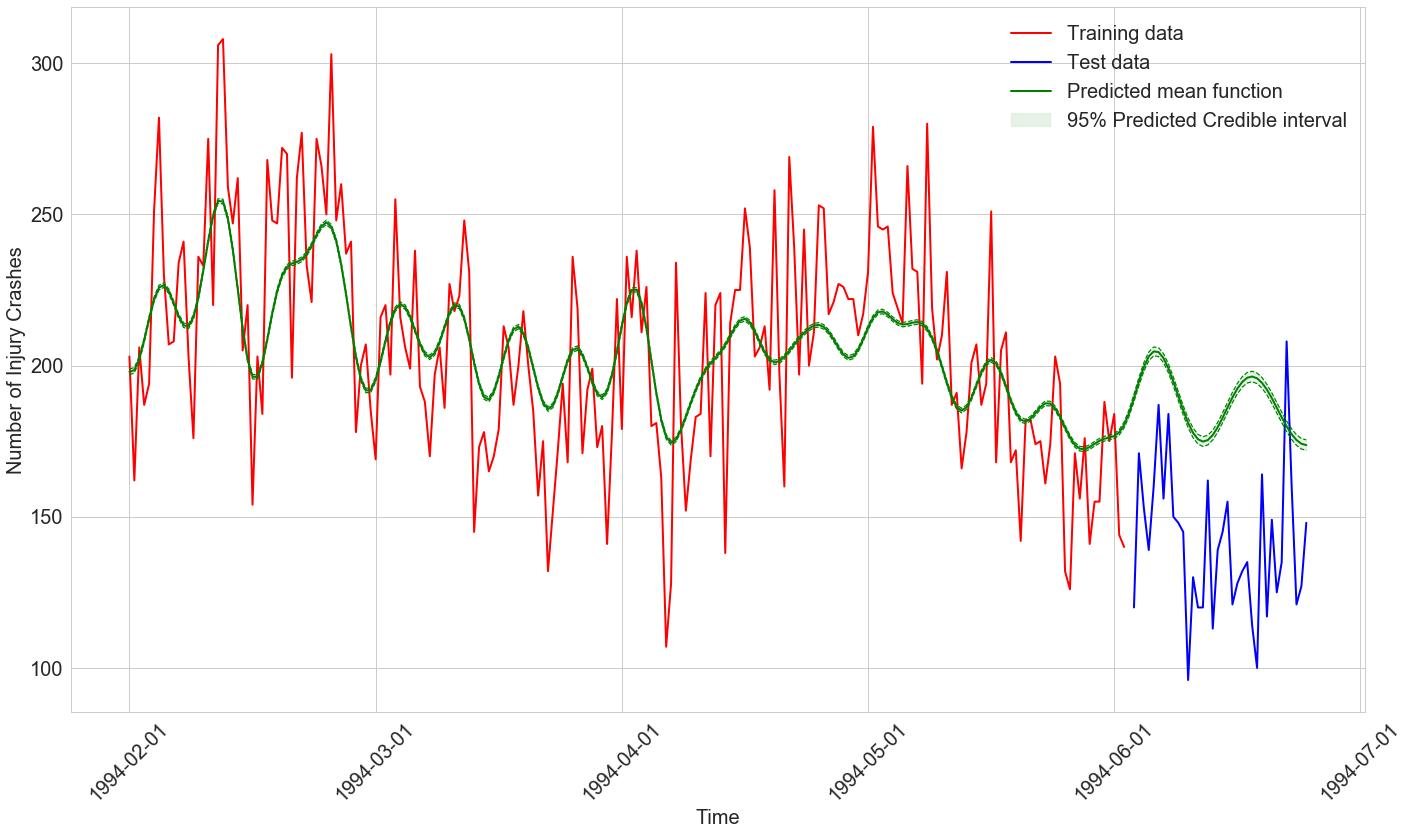

In [30]:
plotprediction(m_opt)

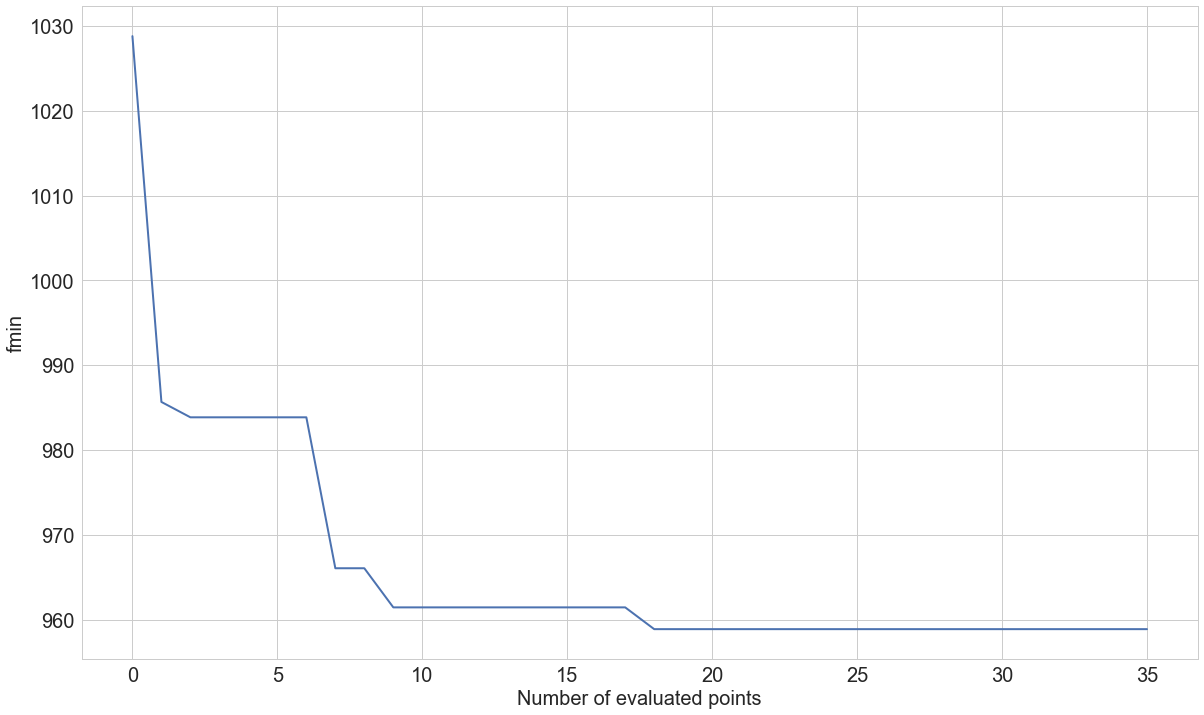

In [78]:
## Inspect the evolution
f, axes = plt.subplots()
f = acq_fn.data[1][:,0]
axes.plot(np.arange(0, acq_fn.data[0].shape[0]), np.minimum.accumulate(f))
axes.set_ylabel('fmin')
axes.set_xlabel('Number of evaluated points');

In [79]:
# # save the model and results to the files 'model.pkl' model_optimized.pkl'
# # and 'results.pkl' for later use
# with open('results-saved/crashes/model.pkl', 'wb') as mdl:
#     pickle.dump(m, mdl, protocol = pickle.HIGHEST_PROTOCOL)
    
# with open('results-saved/crashes/model_optimized.pkl', 'wb') as mdl_opt:
#     pickle.dump(m_opt, mdl_opt, protocol = pickle.HIGHEST_PROTOCOL)    
    
# with open('results-saved/crashes/result_optimized.pkl', 'wb') as res:
#     pickle.dump(result, res, protocol = pickle.HIGHEST_PROTOCOL) 
    
# with open('results-saved/crashes/acq_fn.pkl', 'wb') as acq:
#     pickle.dump(acq_fn, acq, protocol = pickle.HIGHEST_PROTOCOL)  

In [22]:
# # load it at some future point
# with open('results-saved/crashes/model.pkl', 'rb') as mdl:
#     m = pickle.load(mdl)

# with open('results-saved/crashes/model_optimized.pkl', 'rb') as mdl_opt:
#     m_opt = pickle.load(mdl_opt)
    
# with open('results-saved/crashes/result_optimized.pkl', 'rb') as res:
#     result = pickle.load(res)   
    
# with open('results-saved/crashes/acq_fn.pkl', 'rb') as acq:
#     acq_fn = pickle.load(acq)     

In [80]:
# improve quality of figures for journal paper
%config InlineBackend.figure_format = "retina" 

In [81]:
# print system information/setup
%reload_ext watermark
%watermark -v -m -p numpy,pandas,gpflowopt,gpflow,tensorflow,matplotlib,ipywidgets,beakerx,seaborn -g

CPython 3.6.3
IPython 6.2.1

numpy 1.13.3
pandas 0.20.3
gpflowopt 0.1.0
gpflow 0.4.0
tensorflow 1.4.1
matplotlib 2.1.1
ipywidgets 7.1.1
beakerx 0.12.1
seaborn 0.8.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : e4dd6cd511d5452d6871bdb5d964972707ba3328
